In [2]:
import csv
import time
import sys
import matplotlib.pyplot as plt
import numpy as np
import math
import os.path
from scipy.stats import multivariate_normal
import ipywidgets as widgets
from IPython.display import display


In [3]:
def load_data(filename):
    """Load data from the csv log

    Parameters:
    filename (str)  -- the name of the csv log

    Returns:
    data (dict)     -- the logged data with data categories as keys
                       and values list of floats
    """
    is_filtered = False
    if os.path.isfile(filename + "_filtered.csv"):
        f = open(filename + "_filtered.csv")
        is_filtered = True
    else:
        f = open(filename + ".csv")

    file_reader = csv.reader(f, delimiter=',')

    # Load data into dictionary with headers as keys
    data = {}
    header = ["X", "Y", "Z", "Time Stamp", "Latitude", "Longitude",
              "Yaw", "Pitch", "Roll", "AccelX", "AccelY", "AccelZ"]
    for h in header:
        data[h] = []

    row_num = 0
    f_log = open("bad_data_log.txt", "w")
    for row in file_reader:
        for h, element in zip(header, row):
            # If got a bad value just use the previous value
            try:
                data[h].append(float(element))
            except ValueError:
                data[h].append(data[h][-1])
                f_log.write(str(row_num) + "\n")

        row_num += 1
    f.close()
    f_log.close()

    return data, is_filtered

In [4]:
def wrap_to_pi(angle):
    """Wrap angle data in radians to [-pi, pi]

    Parameters:
    angle (float)   -- unwrapped angle

    Returns:
    angle (float)   -- wrapped angle
    """
    while angle >= math.pi:
        angle -= 2*math.pi

    while angle <= -math.pi:
        angle += 2*math.pi
    return angle


In [5]:
def convert_gps_to_xy(lat_gps, lon_gps, lat_origin, lon_origin):
    """Convert gps coordinates to cartesian with equirectangular projection

    Parameters:
    lat_gps     (float)    -- latitude coordinate
    lon_gps     (float)    -- longitude coordinate
    lat_origin  (float)    -- latitude coordinate of your chosen origin
    lon_origin  (float)    -- longitude coordinate of your chosen origin

    Returns:
    x_gps (float)          -- the converted x coordinate
    y_gps (float)          -- the converted y coordinate
    """
    x_gps = EARTH_RADIUS*(math.pi/180.)*(lon_gps - lon_origin)*math.cos((math.pi/180.)*lat_origin)
    y_gps = EARTH_RADIUS*(math.pi/180.)*(lat_gps - lat_origin)

    return x_gps, y_gps


In [6]:
data17, _ = load_data("2020_2_26__17_21_59_filtered")

In [7]:
#accleration covariance calculations
#assuming uncorrelated Accelx, accelY
var_accX = np.var(data17["AccelX"][669:])
var_accY = np.var(data17["AccelY"][669:])
covar_u_t = np.array([[var_accX, 0],
                      [0, var_accY]])
print(var_accX, var_accY)

0.2597510387811634 0.14175408587257618


In [8]:
HEIGHT_THRESHOLD = 0.0  # meters
GROUND_HEIGHT_THRESHOLD = -.4  # meters
DT = 0.1
X_LANDMARK = 5.  # meters
Y_LANDMARK = -5.  # meters
EARTH_RADIUS = 6.3781E6  # meters

In [9]:
yaw_corrected = np.zeros(len(data17["Yaw"][669:]))
yaw_data = data17["Yaw"][669:]

for i in range(len(data17["Yaw"][669:])):
    
    yaw_corrected[i] = wrap_to_pi(yaw_data[i]*(np.pi/180))

yaw_corrected

array([ 0.01090831,  0.        ,  0.00109083, -0.00436332,  0.        ,
       -0.00109083,  0.00872665,  0.00436332,  0.00654498,  0.00545415,
        0.00654498,  0.00654498,  0.00763582,  0.00654498,  0.00654498,
        0.00654498,  0.00654498,  0.00545415,  0.00545415,  0.00545415,
        0.00545415,  0.00545415,  0.00654498,  0.00654498,  0.00654498,
        0.00654498,  0.00763582,  0.00763582,  0.00763582,  0.00763582,
        0.00763582,  0.00763582,  0.00763582,  0.00763582,  0.00763582,
        0.00763582,  0.00763582,  0.00763582])

In [53]:
#calculating sensor covariance matrix. We assume that all measurements are independent, and that the covariance is equal
#to the stationary variance
#recall: measurement vector is Zx, Zy, yaw
var_Zx = np.var(data17["X"][669:])
var_Zy = np.var(data17["Y"][669:])
var_yaw = np.var(yaw_corrected)
# covar_z = np.array([[var_Zx, 0, 0],
#                     [ 0, var_Zy, 0],
#                     [0, 0, var_yaw]])

covar_z = np.array([[0.1, 0, 0],
                    [ 0, .1, 0],
                    [0, 0, var_yaw]])
print(var_Zx, var_Zy, var_yaw)

0.0001698159186405823 0.0004478908815990326 8.613675903064495e-06


In [11]:
def propogate_state(x_t_prev, u_t):
    """Propogate/predict the state based on chosen motion model

    Parameters:
    x_t_prev (np.array)  -- the previous state estimate
    u_t (np.array)       -- the current control input

    Returns:
    x_bar_t (np.array)   -- the predicted state
    """
    """STUDENT CODE START"""
    #Xt = [xg, yg, yaw, yaw_t-1, Vx, Vy, omega]'
    angle_correction = x_t_prev[2]
    #angle_correction = wrap_to_pi(x_t_prev[2])

    A_matrix = np.array([[1, 0, 0, 0, DT, 0, 0],
                         [0, 1, 0, 0, 0, DT, 0],
                         [0, 0, 1, 0, 0, 0, DT],
                         [0, 0, 1, 0, 0, 0, 0 ],
                         [0, 0, 0, 0, 1, 0, 0 ],
                         [0, 0, 0, 0, 0, 1, 0 ],
                         [0, 0, 1/DT, -1/DT, 0, 0, 0]])
    
    #angle_correction = wrap_to_pi(2*np.pi - x_t_prev[2])
    
    
    #angle_correction = wrap_to_pi(-x_t_prev[2])
    
    #adding perturbation into the yaw, as u_t has no bearing on it
    mean_yaw = 0
    stdev_yaw = 0.5*np.pi/180
    
    random_delta_yaw = np.random.normal(loc = mean_yaw, scale = stdev_yaw)
    
    
    

    #no holonomic motion assumption

    B_matrix = np.array([[1/2*np.square(DT)*np.cos(angle_correction), 0],
                     [-1/2*np.square(DT)*np.sin(angle_correction), 0],
                     [0, 0],
                     [0, 0],
                     [DT*np.cos(angle_correction), 0], 
                     [-DT*np.sin(angle_correction), 0],
                     [0, 0]])
    
#     B_matrix = np.array([[1/2*np.square(DT)*np.cos(angle_correction), 1/2*np.square(DT)*np.sin(angle_correction)],
#                      [-1/2*np.square(DT)*np.sin(angle_correction), 1/2*np.square(DT)*np.cos(angle_correction)],
#                      [0, 0],
#                      [0, 0],
#                      [DT*np.cos(angle_correction), DT*np.sin(angle_correction)], 
#                      [-DT*np.sin(angle_correction), DT*np.cos(angle_correction)],
#                      [0, 0]])

    x_bar_t = A_matrix@x_t_prev + B_matrix@u_t
    x_bar_t[2] = wrap_to_pi((A_matrix@x_t_prev)[2] + (B_matrix@u_t)[2] + random_delta_yaw)
    x_bar_t[3] = wrap_to_pi((A_matrix@x_t_prev)[3] + (B_matrix@u_t)[3])
    
    
    x_bar_t[6] = wrap_to_pi(x_t_prev[2] - x_t_prev[3]) / DT
    #x_bar_t[6] = (wrap_to_pi(x_t_prev[2]) - wrap_to_pi(x_t_prev[3])) / DT
    #x_bar_t[2] = wrap_to_pi(x_bar_t[2])

    """STUDENT CODE END"""

    return x_bar_t

In [34]:
def propogate_state2(x_t_prev, u_t):
    """
    propogate the state using random forward motion
    
    Assumes no slide slipping
    """
    
# #     #based on time to travel on side in experiment. assuming constant velocity, m/s
#     mean_speed = 0.5*DT*u_t[0]
#     stdev_speed = np.abs(mean_speed/2) #arbitrary, picked to ensure 0 m/s possible

#     random_velocity = np.random.normal(loc = mean_speed, scale = stdev_speed)

    mean_motion = 0.07
    std_motion = 0.06
    random_forward = np.random.normal(loc = mean_motion, scale = std_motion)

    mean_yaw = 0
    stdev_yaw = 0.05#5*np.pi/180
    
    random_delta_yaw = np.random.normal(loc = mean_yaw, scale = stdev_yaw)
    
    curr_yaw = wrap_to_pi(x_t_prev[2] + random_delta_yaw)
    
#     rot = np.array([[np.cos(curr_yaw), np.sin(curr_yaw)],
#                     [-np.sin(curr_yaw), np.cos(curr_yaw)]])

    rot = np.array([[np.cos(curr_yaw), 0],
                    [-np.sin(curr_yaw), 0]])
    
#     global_velocities = rot @ np.array([random_velocity, 0])

    forward_motion = rot @ np.array([random_forward, 0])
    
    x_t = np.zeros((3,1))
    x_t[0] = x_t_prev[0] + forward_motion[0]
    x_t[1] = x_t_prev[1] + forward_motion[1]
    x_t[2] = curr_yaw
    
    x_t = x_t.flatten()
    
    return x_t    

## State Representation

### At each time step, the ith row of the particle matrix has the states corresponding to the ith particle 

In [24]:
def getWeight(x_t, z_t, covar_z_t):
    
    estimated = x_t[0:3]
    
#     print("estimated measurement ", estimated)
#     print("actual measurement ", z_t, "\n")
    
    
    weight = multivariate_normal.pdf(z_t, mean=estimated, cov=covar_z_t)
    
#     if weight == 0:
#         print("getWeight")
#         print('x_t')
#         print(x_t)
#         print('estimated')
#         print(estimated)
#         print('z_t')
#         print(z_t)
#         print('weight')
#         print(weight)
#         print("wtf")
    
    return weight
    

In [30]:
def prediction_step(x_t_prev, u_t, covar_u_t, z_t, covar_z_t):
    '''
    z_t is the bot's position in the global frame
    
    '''
    
    x_t_bar = np.zeros(x_t_prev.shape)
    weights = np.zeros(len(x_t_prev))
    
    for i in range(len(x_t_prev)):
        perturbed_u_t = np.zeros(2)
        
        # Get previous state
        prev_state = x_t_prev[i]
        
        # Perturb control input
        perturbed_u_t[0] = u_t[0] + np.random.normal(loc = 0, scale = np.sqrt(covar_u_t[0][0]))
        perturbed_u_t[1] = u_t[1] + np.random.normal(loc = 0, scale = np.sqrt(covar_u_t[1][1]))
        
        # Get new state using perturbed control input
        new_state = propogate_state2(prev_state, perturbed_u_t)
        new_weight = getWeight(new_state, z_t, covar_z_t)

        
        # Store
        x_t_bar[i] = new_state
        weights[i] = new_weight
        
    print(np.sum(weights))
        
#     if np.isnan(np.sum(weights)):
#         print("")
#         print(x_t_prev)
#         print(z_t)
#         print(weights)
#         print('')
    epsilon = 1e-12
    weights_sum = weights/(np.sum(weights))
    
    
#     if np.isnan(np.sum(weights_sum)):
#         print(x_t_prev)
#         print(z_t)
#         print(weights)
#         print(np.sum(weights))
    #print(np.sum(weights))
    
    
#     for i in range(len(x_t_prev)):
        
#         print("Particle # is: ", i)
#         print("Prev state is: ", x_t_prev[i])
#         print("propogated State is: ", x_t_bar[i])
#         print("Weight is: ", weights_sum[i])
#         print("current Max is: ", np.max(weights_sum[0:i+1]))
#         print()
        
    return x_t_bar, weights_sum
        
    

In [15]:
def correction_step(x_bar_t, weights):
    
    x_t = np.zeros(x_bar_t.shape)
    #weights = np.zeros(len(x_bar_t))
        
    x_ind = np.arange(len(x_bar_t))
    
    for i in range(len(x_bar_t)):
        
        #print(x_ind.shape)
        #print(weights.shape)
        #print("correction")
        #print(np.sum(weights))
        
#         if np.isnan(np.sum(weights)):
#             print(weights)
        x_t_index = np.random.choice(a = x_ind, p = weights)
        
        x_t[i] = x_bar_t[x_t_index]
        #weights[i] = weights[x_t_index]
        
        #print("resampled particle: ", x_t_index)
        
    return x_t
        

In [16]:
def initializeParticles(numParticles, numStates):
    
    states = np.zeros([numParticles, numStates])
    
    #x: 0.157586
    #y: -0.145739
    
    x_col = np.random.normal(loc = 0, scale = 0.25, size = numParticles)
    y_col = np.random.normal(loc = 0, scale = 0.25, size = numParticles)
    
    yaw_col = np.random.normal(loc = 0, scale = 0.01, size = numParticles)
    #yaw_col = np.where(yaw_col < 0, yaw_col + np.pi*2, yaw_col)
    
     
    
    states[:, 0] = x_col
    states[:, 1] = y_col
    states[:, 2] = yaw_col
    states[:, 3] = yaw_col
        
    return states
    
    

In [17]:
def initializeParticles2(numParticles, numStates):
    
    """
    initialize for only x, y, and theta
    """
    
    states = np.zeros([numParticles, numStates])
    
    x_col = np.random.normal(loc = 0.157586, scale = 0.25, size = numParticles)
    y_col = np.random.normal(loc = -0.145739, scale = 0.25, size = numParticles)
    
    yaw_col = np.random.normal(loc = 0, scale = 0.01, size = numParticles)
    #yaw_col = np.where(yaw_col < 0, yaw_col + np.pi*2, yaw_col)
    
    states[:, 0] = x_col
    states[:, 1] = y_col
    states[:, 2] = yaw_col
    
    return states

In [18]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [28]:
def main():
    
    filename = '2020_2_26__17_21_59_filtered'
    data, is_filtered = load_data(filename)
    
    # Load data into variables
    x_lidar = data["X"]
#     x_lidar = running_mean(x_lidar, 10)
    y_lidar = data["Y"]
#     y_lidar = running_mean(y_lidar, 10)
    z_lidar = data["Z"]
    time_stamps = data["Time Stamp"]
    lat_gps = data["Latitude"]
    lon_gps = data["Longitude"]
    yaw_lidar = data["Yaw"]
#     yaw_lidar = running_mean(yaw_lidar, 10)
    pitch_lidar = data["Pitch"]
    roll_lidar = data["Roll"]
    x_ddot = data["AccelX"]
    y_ddot = data["AccelY"]
    
    lat_origin = lat_gps[0]
    lon_origin = lon_gps[0]
    
    # Initialize filter
    numParticles = 1000
    numStates = 3
#     x_t_prev = initializeParticles(numParticles, numStates) #7 element state
    x_t_prev = initializeParticles2(numParticles, numStates) #3 element state
    
    # Store particles and gps
    particles = np.empty((numParticles, numStates, len(time_stamps)))
    vis_particles = np.empty((len(time_stamps), 2, numParticles))
    gps_estimates = np.empty((2, len(time_stamps)))
    weights_out = np.zeros((numParticles, len(time_stamps)))
    z_t_out = np.zeros((3, len(time_stamps)))
    
    converted_yaws = np.zeros(len(time_stamps))
#     z_ts = np.zeros((3, len(time_stamps)-10))
#     for t, _ in enumerate(time_stamps[0:-10]):
#         converted_yaws[t] = wrap_to_pi(yaw_lidar[t] * np.pi / 180)

#         z_ts[:, t] = np.array([5 - (x_lidar[t]*(-np.sin(converted_yaws[t])) + y_lidar[t]*(np.cos(converted_yaws[t]))),
#                             -5 - (x_lidar[t]*(-np.cos(converted_yaws[t])) - y_lidar[t]*(np.sin(converted_yaws[t]))),
#                             converted_yaws[t]])
        
#     z_ts[0, :] = running_mean(z_ts[0, :], 10)
#     z_ts[1, :] = running_mean(z_ts[1, :], 10)
#     z_ts[2, :] = running_mean(z_ts[2, :], 10)

    
    for t, _ in enumerate(time_stamps):
        print(t)
        
#         print("timestep = ", t)
#         print("previous x = ", x_t_prev)
        
        u_t = np.array([x_ddot[t], y_ddot[t]])
        
        #converted_yaw = converted_yaws[t]
        #z_t = z_ts[:, t]
        
        converted_yaw = wrap_to_pi(yaw_lidar[t] * np.pi / 180)
        
        z_t = np.array([5 - (x_lidar[t]*(-np.sin(converted_yaw)) + y_lidar[t]*(np.cos(converted_yaw))),
                        -5 - (x_lidar[t]*(-np.cos(converted_yaw)) - y_lidar[t]*(np.sin(converted_yaw))),
                        converted_yaw])
        
        # Prediction Step
#         print("time stamp: ", t)
        x_bar_t, weights = prediction_step(x_t_prev, u_t, covar_u_t, z_t, covar_z)
        #print(np.sum(weights))
#         print("predicted x = ", x_bar_t)
#         print()
        
        # Correction Step
#         x_t = correction_step(x_bar_t, weights)
        
        try:
            x_t = correction_step(x_bar_t, weights)
            
        except:
            print("Something went wrong at t=", t)
            particles[:, :, t] = x_t
            weights_out[:, t] = weights
            return particles, vis_particles, gps_estimates, t, weights_out, z_t_out
        
        
        # Explicitly set x_t_prev to x_t
        x_t_prev = x_t
        
        # Store shit
        particles[:, :, t] = x_t
        
        vis_particles[t,0] = particles[:, 0, t].flatten()
        vis_particles[t,1] = particles[:, 1, t].flatten()

        x_gps, y_gps = convert_gps_to_xy(lat_gps=lat_gps[t],
                                         lon_gps=lon_gps[t],
                                         lat_origin=lat_origin,
                                         lon_origin=lon_origin)
        
        gps_estimates[:, t] = np.array([x_gps, y_gps])
        
        weights_out[:, t] = weights
        
        z_t_out[:, t] = z_t
               
    return particles, vis_particles, gps_estimates, t, weights_out, z_t_out
    

In [54]:
P_t, particles, gps_estimates, lastIdx, weights, z_t = main()



0
7438.925719153673
1
7229.146621985541
2
9635.130497476886
3
6576.708558503867
4
7489.581516698561
5
7573.48205445
6
9864.369774530962
7
7777.970591146997
8
7108.655728697092
9
7603.889797673247
10
6946.819557081416
11
6845.651831013084
12
7771.5907397965975
13
3682.687100082332
14
6251.9132724172105
15
4885.599905061459
16
6419.309277330159
17
6536.221158152505
18
8226.223647921677
19
7722.6885843312675
20
7424.798773514649
21
6609.669596741589
22
8129.094669943264
23
8183.9351482369275
24
10482.325904254976
25
8001.870082565782
26
9816.670871681396
27
8109.195822223482
28
8467.03100448373
29
8784.415142777416
30
10243.017757659793
31
12574.009300397734
32
11322.903562282241
33
11239.149595458708
34
10120.085292471173
35
10212.842970899359
36
10812.895122121194
37
13540.608456151811
38
11607.407853351095
39
10833.353347745822
40
10894.408281247335
41
11638.607839258526
42
10884.283369545825
43
9226.252390711157
44
11649.181811310415
45
12031.235709701436
46
9312.160768090627
47
9768.

374
713.3043846159096
375
839.3661815144378
376
1662.5196598853124
377
2210.521897519875
378
2674.4499349424696
379
3720.3695395749387
380
4716.137748753428
381
4689.332999166099
382
4586.953658074903
383
4367.983116522337
384
5318.1463432985
385
6516.813300825172
386
5713.758756597832
387
3950.7771453105347
388
6585.952586258776
389
5182.293572435131
390
5924.433240226912
391
6265.074092496479
392
6414.50638823102
393
6723.676031305482
394
6497.8860902777915
395
7067.994420411969
396
6544.477935341809
397
6072.2692764232825
398
5419.9141335439
399
4641.514550870734
400
6494.774180312637
401
6745.427628420068
402
7433.24550326208
403
6802.083283927947
404
6342.254786710523
405
5979.756819173681
406
6483.63808297484
407
4624.93220653272
408
5849.294613316491
409
5178.847915454506
410
5104.843125831063
411
3377.3553623084417
412
5213.389892483512
413
4941.012583463507
414
2924.802050717066
415
3880.829135824648
416
3954.838726302929
417
4775.792613814323
418
2827.32886240182
419
2929.199

In [55]:
print(lastIdx)
P_t = P_t[:, :, 0:lastIdx]
weights = weights[:, 0:lastIdx]
z_t = z_t[:, 0:lastIdx]

706


<IPython.core.display.Javascript object>


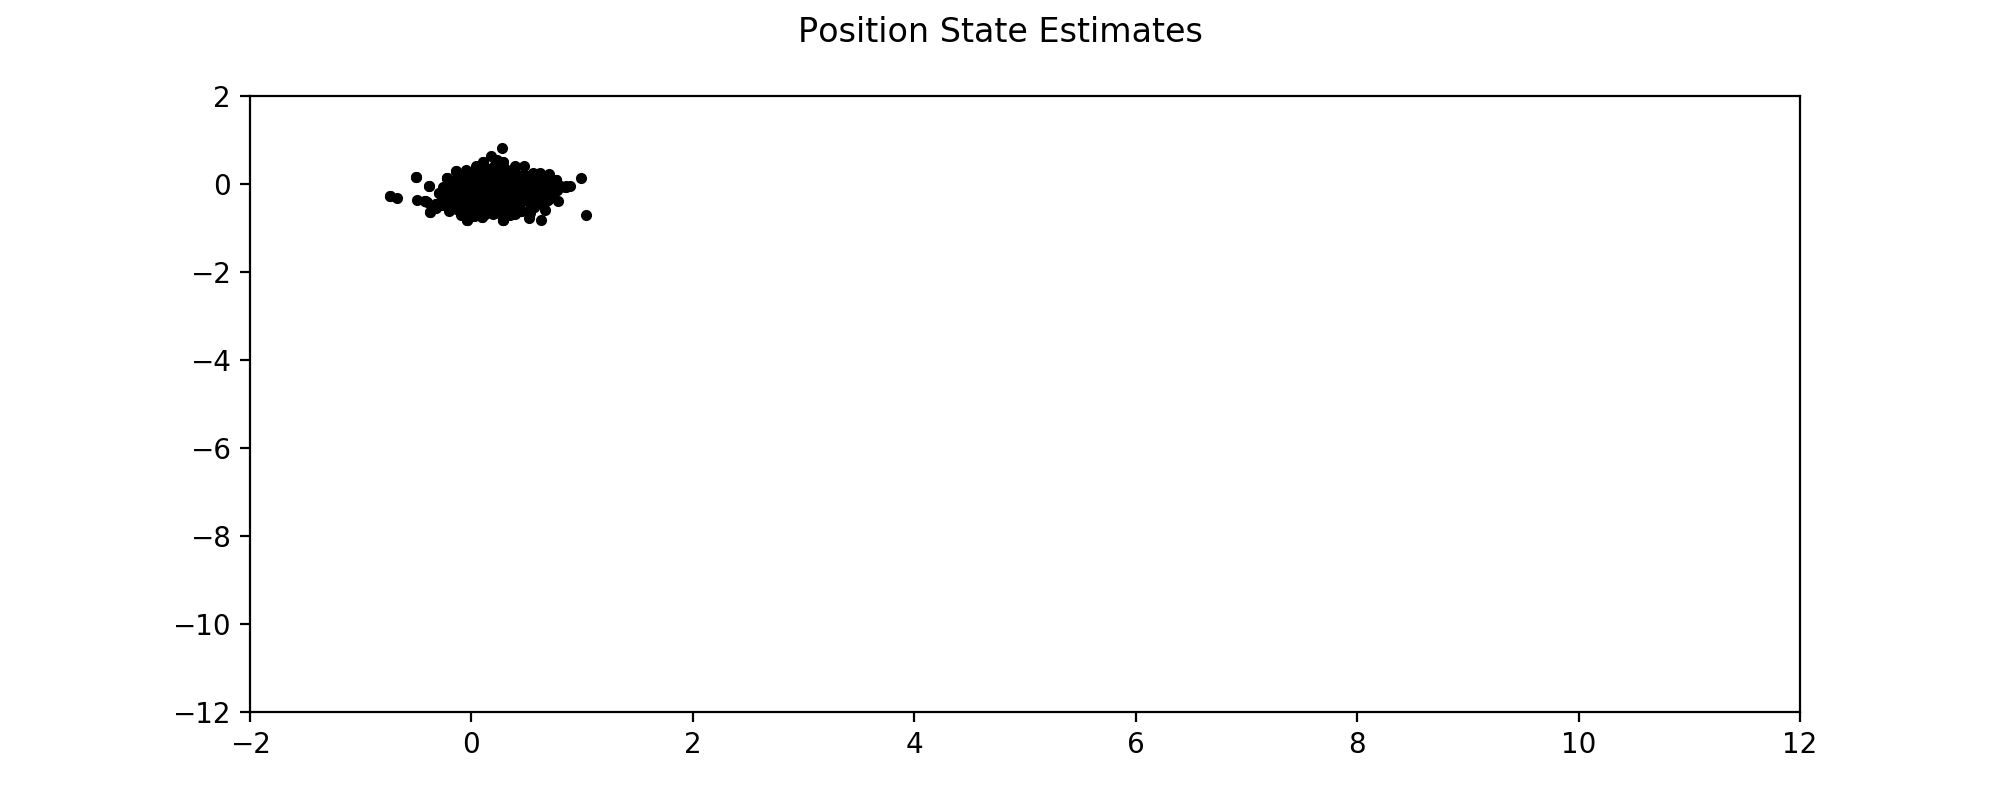

interactive(children=(IntSlider(value=0, description='Time Step', max=705), Output()), _dom_classes=('widget-i…

In [40]:
%matplotlib nbagg
### Plot X, Y particles states w/ slider
particles_to_plot = P_t
fig, ax = plt.subplots(1, figsize=(10, 4))
plt.suptitle('Position State Estimates')

minTimeStep = 0
maxTimeStep = particles_to_plot.shape[2]


def update_plot(time_pos):
    
    ax.clear()
    x_positions = particles_to_plot[:, 0, time_pos]
    y_positions = particles_to_plot[:, 1, time_pos]
    ax.plot(x_positions, y_positions, "k.")
    ax.set_xlim((-2, 12))
    ax.set_ylim((-12, 2))
    
    
#     y = amp * np.sin(freq * 2 * np.pi * x + phase * 2 * np.pi)
#     units = 'amp = {} $(psi)$ \nphase = {} $(s)$ \nfreq = {} $(Hz)$'
    
#     ax.plot(x, y, label=units.format(amp, phase, freq))
#     ax.set_xlim(x[0], x[-1])
#     ax.legend(loc=1)
#     ax.set_xlabel('$(s)$')
    plt.show()


# amp = widgets.FloatSlider(min=1, max=10, value=1, description='Amp:')
# phase = widgets.FloatSlider(min=0, max=5, value=0, description='Phase:')
time_pos = widgets.IntSlider(min=minTimeStep, max=maxTimeStep-1, value=0, description='Time Step')
    
widgets.interactive(update_plot, time_pos=time_pos)

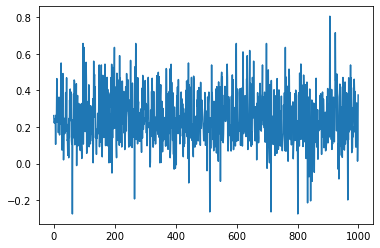

In [41]:
%matplotlib inline
plt.plot(P_t[:, 1, -1])

In [56]:
P_t_x = []
P_t_y = []

for i in range(706):
    
    P_t_x.append(np.mean(P_t[:,0,i]))
    P_t_y.append(np.mean(P_t[:,1,i]))
    

#P_t = P_t[:, :, 0:lastIdx]


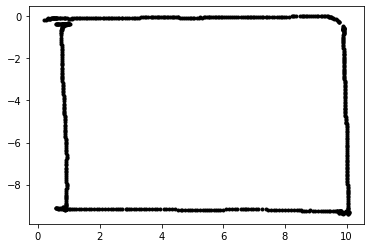

In [57]:
plt.plot(P_t_x, P_t_y, 'k.')

In [42]:
P_t.shape

(1000, 3, 706)

In [48]:
P_t[:, 0, 1].shape

(1000,)

<IPython.core.display.Javascript object>


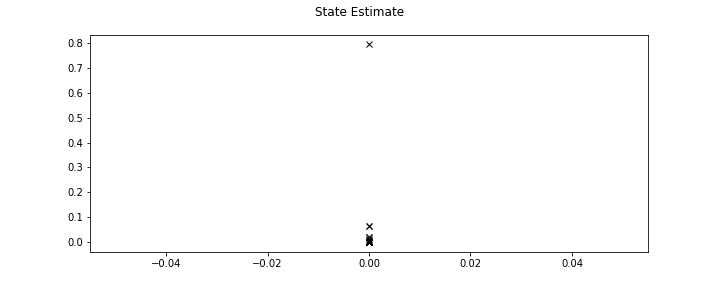

interactive(children=(IntSlider(value=0, description='Time Step', max=231), Output()), _dom_classes=('widget-i…

In [283]:
### Plot yaw w/ slider
%matplotlib notebook

particles_to_plot = P_t
fig, ax = plt.subplots(1, figsize=(10, 4))
plt.suptitle('State Estimate')

minTimeStep = 0
maxTimeStep = particles_to_plot.shape[2]


def update_plot_yaw(time_yaw):
    
    ax.clear()
    yaw = particles_to_plot[:, 2, time_yaw]
    times = np.ones(yaw.size)*time_yaw
    ax.plot(times, yaw, "kx")
#     ax.set_xlim((-2, 12))
#     ax.set_ylim((-0.35, 0.15))
    
    
#     y = amp * np.sin(freq * 2 * np.pi * x + phase * 2 * np.pi)
#     units = 'amp = {} $(psi)$ \nphase = {} $(s)$ \nfreq = {} $(Hz)$'
    
#     ax.plot(x, y, label=units.format(amp, phase, freq))
#     ax.set_xlim(x[0], x[-1])
#     ax.legend(loc=1)
#     ax.set_xlabel('$(s)$')
    plt.show()


# amp = widgets.FloatSlider(min=1, max=10, value=1, description='Amp:')
# phase = widgets.FloatSlider(min=0, max=5, value=0, description='Phase:')
time_yaw = widgets.IntSlider(min=minTimeStep, max=maxTimeStep-1, value=0, description='Time Step')
    
widgets.interactive(update_plot_yaw, time_yaw=time_yaw)

In [274]:
weights.shape

(5000, 195)

<IPython.core.display.Javascript object>


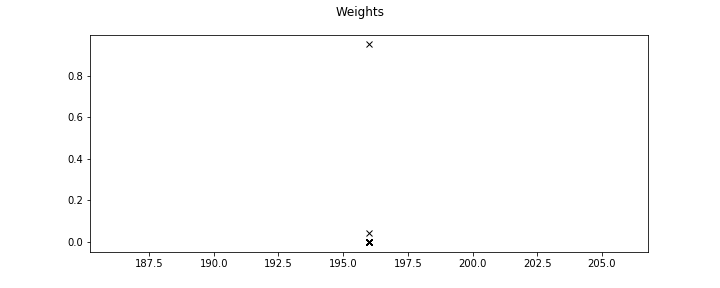

interactive(children=(IntSlider(value=0, description='Time Step', max=231), Output()), _dom_classes=('widget-i…

In [363]:
### Plot yaw w/ slider
%matplotlib notebook

weight_to_plot = weights
fig, ax = plt.subplots(1, figsize=(10, 4))
plt.suptitle('Weights')

minTimeStep = 0
maxTimeStep = weight_to_plot.shape[1]


def update_plot_weight(time_weight):
    
    ax.clear()
    weight = weight_to_plot[:, time_weight]
    times = np.ones(weight.size)*time_weight
    ax.plot(times, weight, "kx")
#     ax.set_xlim((-2, 12))
#     ax.set_ylim((-0.35, 0.15))
    
    
#     y = amp * np.sin(freq * 2 * np.pi * x + phase * 2 * np.pi)
#     units = 'amp = {} $(psi)$ \nphase = {} $(s)$ \nfreq = {} $(Hz)$'
    
#     ax.plot(x, y, label=units.format(amp, phase, freq))
#     ax.set_xlim(x[0], x[-1])
#     ax.legend(loc=1)
#     ax.set_xlabel('$(s)$')
    plt.show()


# amp = widgets.FloatSlider(min=1, max=10, value=1, description='Amp:')
# phase = widgets.FloatSlider(min=0, max=5, value=0, description='Phase:')
time_weight = widgets.IntSlider(min=minTimeStep, max=maxTimeStep-1, value=0, description='Time Step')
    
widgets.interactive(update_plot_weight, time_weight=time_weight)

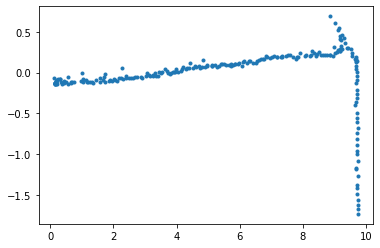

In [389]:
%matplotlib inline
plt.plot(z_t[0], z_t[1], ".")
# plt.xlim((8, 10))
# plt.ylim((-1, 1))

In [379]:
ts = -41
print("z_t is ", z_t[:, ts])
print()
x = np.unique(P_t[:, :, ts], axis = 0)
print(x)

z_t is  [9.29391995 0.42730142 0.89011792]

[[ 9.26547879 -0.11633101  0.87517201]]


In [380]:
ts = -39
print("z_t is ", z_t[:, ts])
print()
x = np.unique(P_t[:, :, ts], axis = 0)
print(x)

z_t is  [9.56009722 0.23747782 1.0842858 ]

[[ 9.24489685 -0.10194912  1.08582669]
 [ 9.25289409 -0.11621168  1.07984837]
 [ 9.25428319 -0.11899736  1.0810355 ]
 [ 9.25505607 -0.12124999  1.08595635]
 [ 9.26232985 -0.13340288  1.07746889]
 [ 9.26450493 -0.13939336  1.08694552]
 [ 9.26500464 -0.1392342   1.08163794]
 [ 9.26897307 -0.14919508  1.09254445]
 [ 9.26910375 -0.14533253  1.07444042]
 [ 9.27492594 -0.15765637  1.08077899]
 [ 9.2750467  -0.15619599  1.07399308]
 [ 9.2784894  -0.16341984  1.07732561]
 [ 9.28561874 -0.17845915  1.08329393]
 [ 9.28637843 -0.17931629  1.08140425]
 [ 9.29019376 -0.18543901  1.07814071]
 [ 9.2938681  -0.19209714  1.07758006]]


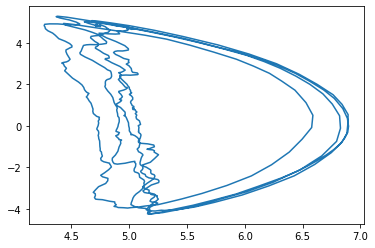

In [397]:
%matplotlib inline

yaw_wrapped = np.zeros(len(data17["Yaw"]))
yaw_data = data17["Yaw"]

x_lidar = data17["X"]
x_lidar = running_mean(x_lidar, 3)
y_lidar = data17["Y"]
y_lidar = running_mean(y_lidar, 3)
yaw_lidar = data17["Yaw"]
yaw_lidar = running_mean(yaw_lidar, 3)

for i in range(len(data17["Yaw"])):
    
    yaw_wrapped[i] = wrap_to_pi(yaw_data[i]*(np.pi/180))

yaw_wrapped

plt.plot(x_lidar, y_lidar)

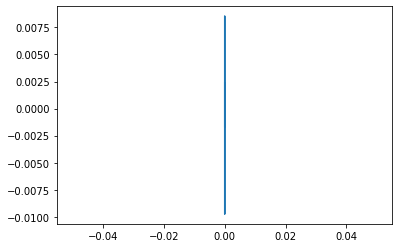

In [23]:
%matplotlib inline

plt.plot(np.ones(P_t[:, 2, 170].shape)*0, P_t[:, 2, 0])


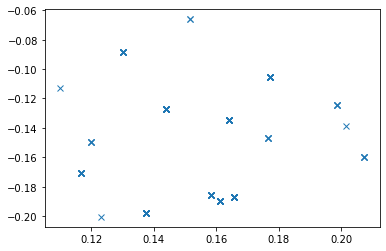

In [24]:
%matplotlib inline
plt.plot(P_t[:, 0, 0], P_t[:, 1, 0], "x")
plt.show()

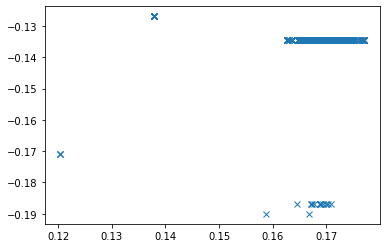

In [25]:
%matplotlib inline
plt.plot(P_t[:, 0, 1], P_t[:, 1, 1], "x")
plt.show()

<IPython.core.display.Javascript object>


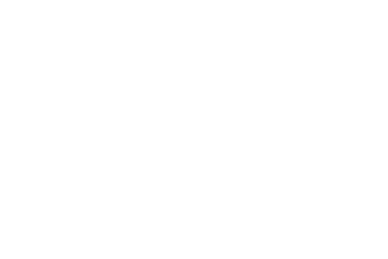

<IPython.core.display.Javascript object>


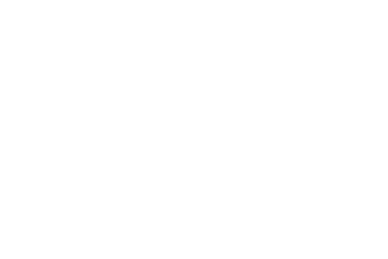

In [26]:
#visualization, provided by Varun
from matplotlib.widgets import Slider
%matplotlib notebook

fig, ax = plt.subplots()
time_stamps = np.arange(31)
t = np.arange(len(time_stamps))
PARTICLE_TIME = 0
plt.subplots_adjust(left=0.25, bottom=0.25)
particles_data, = plt.plot(particles[0,0], particles[0,1], '.')
# ax.set_ylim(-150, 150)
# ax.set_xlim(-1500, 1500)

axcolor = 'lightgoldenrodyellow'

timeax = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)
timeSlider = Slider(timeax, 'Timestep', valmin=0, valmax=len(time_stamps)-1, valinit=0, valstep=1)

def update(val):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    PARTICLE_TIME = timeSlider.val
    particles_data.set_xdata(particles[PARTICLE_TIME, 0, :])
    particles_data.set_ydata(particles[PARTICLE_TIME, 1, :])

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    fig.canvas.draw_idle()
    print(PARTICLE_TIME)

timeSlider.on_changed(update)
plt.show()

In [27]:
%matplotlib inline
test = np.ones(1000)/1000

In [28]:
np.random.choice(a = np.arange(1000), p = test)

703

In [29]:
   
filename = '2020_2_26__17_21_59_filtered'
data, is_filtered = load_data(filename)

# Load data into variables
x_lidar = data["X"]
y_lidar = data["Y"]
z_lidar = data["Z"]
time_stamps = data["Time Stamp"]
lat_gps = data["Latitude"]
lon_gps = data["Longitude"]
yaw_lidar = data["Yaw"]
pitch_lidar = data["Pitch"]
roll_lidar = data["Roll"]
x_ddot = data["AccelX"]
y_ddot = data["AccelY"]

lat_origin = lat_gps[0]
lon_origin = lon_gps[0]

# Initialize filter
numParticles = 1000
numStates = 3 #7
#x_t_prev = initializeParticles(numParticles, numStates) #7 element state
x_t_prev = initializeParticles2(numParticles, numStates) #3 element state

# Store particles and gps
particles = np.empty((numParticles, numStates, len(time_stamps)))
vis_particles = np.empty((len(time_stamps), 2, numParticles))
gps_estimates = np.empty((2, len(time_stamps)))

index = 0

for t, _ in enumerate(time_stamps):
    #print('Index')
    #print(index)
    index = index + 1

    u_t = np.array([x_ddot[t], y_ddot[t]])

    converted_yaw = wrap_to_pi(yaw_lidar[t] * np.pi / 180)

    z_t = np.array([5 - (x_lidar[t]*(-np.sin(converted_yaw)) + y_lidar[t]*(np.cos(converted_yaw))),
                    -5 - (x_lidar[t]*(-np.cos(converted_yaw)) - y_lidar[t]*(np.sin(converted_yaw))),
                    converted_yaw])

    # Prediction Step
    x_bar_t, weights = prediction_step(x_t_prev, u_t, covar_u_t, z_t, covar_z)
    #print(np.sum(weights))

    # Correction Step
    #x_t = correction_step(x_bar_t, weights)
    x_t = x_bar_t


    # Explicitly set x_t_prev to x_t
    x_t_prev = x_t

    # Store shit
    particles[:, :, t] = x_t

    vis_particles[t,0] = particles[:, 0, t].flatten()
    vis_particles[t,1] = particles[:, 1, t].flatten()

    x_gps, y_gps = convert_gps_to_xy(lat_gps=lat_gps[t],
                                     lon_gps=lon_gps[t],
                                     lat_origin=lat_origin,
                                     lon_origin=lon_origin)
    gps_estimates[:, t] = np.array([x_gps, y_gps])


#         if (t==30):
#             return particles, vis_particles, gps_estimates

    

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 7)

In [ ]:
p_t = particles
particles = vis_particles

In [ ]:
#visualization, provided by Varun
from matplotlib.widgets import Slider
%matplotlib notebook

fig, ax = plt.subplots()
time_stamps = np.arange(31)
t = np.arange(len(time_stamps))
PARTICLE_TIME = 0
plt.subplots_adjust(left=0.25, bottom=0.25)
particles_data, = plt.plot(particles[0,0], particles[0,1], '.')
# ax.set_xlim(-5, 15)
# ax.set_ylim(-15, 5)

axcolor = 'lightgoldenrodyellow'
timeax = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)
timeSlider = Slider(timeax, 'Timestep', valmin=0, valmax=len(time_stamps)-1, valinit=0, valstep=1)

def update(val):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    PARTICLE_TIME = timeSlider.val
    particles_data.set_xdata(particles[PARTICLE_TIME, 0, :])
    particles_data.set_ydata(particles[PARTICLE_TIME, 1, :])

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    fig.canvas.draw_idle()

timeSlider.on_changed(update)
plt.show()